In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)  # To find local version of the library

from utils.utils import *
from credentials.blob_credentials import facts_sas_token, facts_container, workspace_sas_token, workspace_container
from azure.storage.blob import ContainerClient, BlobClient
import pandas as pd

IMAGE_DIR  = os.path.join(ROOT_DIR, "eleven_images")
if not os.path.exists(IMAGE_DIR):
    os.mkdir(IMAGE_DIR)

    
IMAGE_COLLECTION_PATH = os.path.join(ROOT_DIR, "image_collection_bis.json")

Using TensorFlow backend.


# 1. Fetch metadata

In [2]:
records = fetch_train_set()

In [3]:
records.head(5)

,sample_id,construction_site,image_blob_id,date_time,annotation_people_blob_id,annotation_poly_blob_id,annotation_blob_id
0,2020-08-06-07-00-08,Analytic2,Analytics_Train_Set/Analytics_Train_Set_Img/20...,2020-08-06 07:00:08,Analytics_Train_Set/Analytics_Train_Set_Json/p...,Analytics_Train_Set/Analytics_Train_Set_Json/p...,NaN
1,2020-08-06-07-00-56,Analytic2,Analytics_Train_Set/Analytics_Train_Set_Img/20...,2020-08-06 07:00:56,Analytics_Train_Set/Analytics_Train_Set_Json/p...,Analytics_Train_Set/Analytics_Train_Set_Json/p...,NaN
2,2020-08-06-07-01-43,Analytic2,Analytics_Train_Set/Analytics_Train_Set_Img/20...,2020-08-06 07:01:43,Analytics_Train_Set/Analytics_Train_Set_Json/p...,Analytics_Train_Set/Analytics_Train_Set_Json/p...,NaN
3,2020-08-06-07-02-30,Analytic2,Analytics_Train_Set/Analytics_Train_Set_Img/20...,2020-08-06 07:02:30,Analytics_Train_Set/Analytics_Train_Set_Json/p...,Analytics_Train_Set/Analytics_Train_Set_Json/p...,NaN
4,2020-08-06-07-03-16,Analytic2,Analytics_Train_Set/Analytics_Train_Set_Img/20...,2020-08-06 07:03:16,Analytics_Train_Set/Analytics_Train_Set_Json/p...,Analytics_Train_Set/Analytics_Train_Set_Json/p...,NaN


In [4]:
# Distribution by construction site
records.construction_site.value_counts()

Analytic2                         2155
Analytic                           999
Marseille_01                       779
Devisubox2_06                      294
Nouveau_campus_03                  260
Roissy_02                          152
BioSAV_BIofiltration_18mois_05      97
Name: construction_site, dtype: int64

In [5]:
records_detect = records[records.construction_site != "Analytic2"]
records_detect = records_detect.reset_index(drop=True)
records_analytic = records[records.construction_site == "Analytic2"]
records_analytic = records_analytic.reset_index(drop=True)

In [6]:
with open(IMAGE_COLLECTION_PATH, 'r') as outfile:
    dataset = json.load(outfile)
dataset_train = dataset["train"]
dataset_val = dataset["val"]

records_detect["role"] = records_detect["sample_id"].\
            apply(lambda x: get_sample_role(x, dataset_train, dataset_val))

# 2. Download dataset (takes a few minutes)

In [7]:
for index, row in records_analytic.iterrows():
    tot_number = len(records_analytic)
    if index % 50 == 0:
        print(f"{index} / {tot_number}")
    download_sample_analytics(row["image_blob_id"],
                              row["annotation_people_blob_id"],
                              row["annotation_poly_blob_id"],
                              row["sample_id"], IMAGE_DIR)

0 / 2155
50 / 2155
100 / 2155
150 / 2155
200 / 2155
250 / 2155
300 / 2155
350 / 2155
400 / 2155
450 / 2155
500 / 2155
550 / 2155
600 / 2155
650 / 2155
700 / 2155
750 / 2155
800 / 2155
850 / 2155
900 / 2155
950 / 2155
1000 / 2155
1050 / 2155
1100 / 2155
1150 / 2155
1200 / 2155
1250 / 2155
1300 / 2155
1350 / 2155
1400 / 2155
1450 / 2155
1500 / 2155
1550 / 2155
1600 / 2155
1650 / 2155
1700 / 2155
1750 / 2155
1800 / 2155
1850 / 2155
1900 / 2155
1950 / 2155
2000 / 2155
2050 / 2155
2100 / 2155
2150 / 2155


In [8]:
for index, row in records_detect.iterrows():
    tot_number = len(records_detect)
    if index % 50 == 0:
        print(f"{index} / {tot_number}")
    download_sample(row["image_blob_id"], row["annotation_blob_id"], \
                    row["sample_id"], IMAGE_DIR)

0 / 2581
50 / 2581
100 / 2581
150 / 2581
200 / 2581
250 / 2581
300 / 2581
350 / 2581
400 / 2581
450 / 2581
500 / 2581
550 / 2581
600 / 2581
650 / 2581
700 / 2581
750 / 2581
800 / 2581
850 / 2581
900 / 2581
950 / 2581
1000 / 2581
1050 / 2581
1100 / 2581
1150 / 2581
1200 / 2581
1250 / 2581
1300 / 2581
1350 / 2581
1400 / 2581
1450 / 2581
1500 / 2581
1550 / 2581
1600 / 2581
1650 / 2581
1700 / 2581
1750 / 2581
1800 / 2581
1850 / 2581
1900 / 2581
1950 / 2581
2000 / 2581
2050 / 2581
2100 / 2581
2150 / 2581
2200 / 2581
2250 / 2581
2300 / 2581
2350 / 2581
2400 / 2581
2450 / 2581
2500 / 2581
2550 / 2581


# 3. Choose one sample to visualize (Detect_Train_Set + Bis)

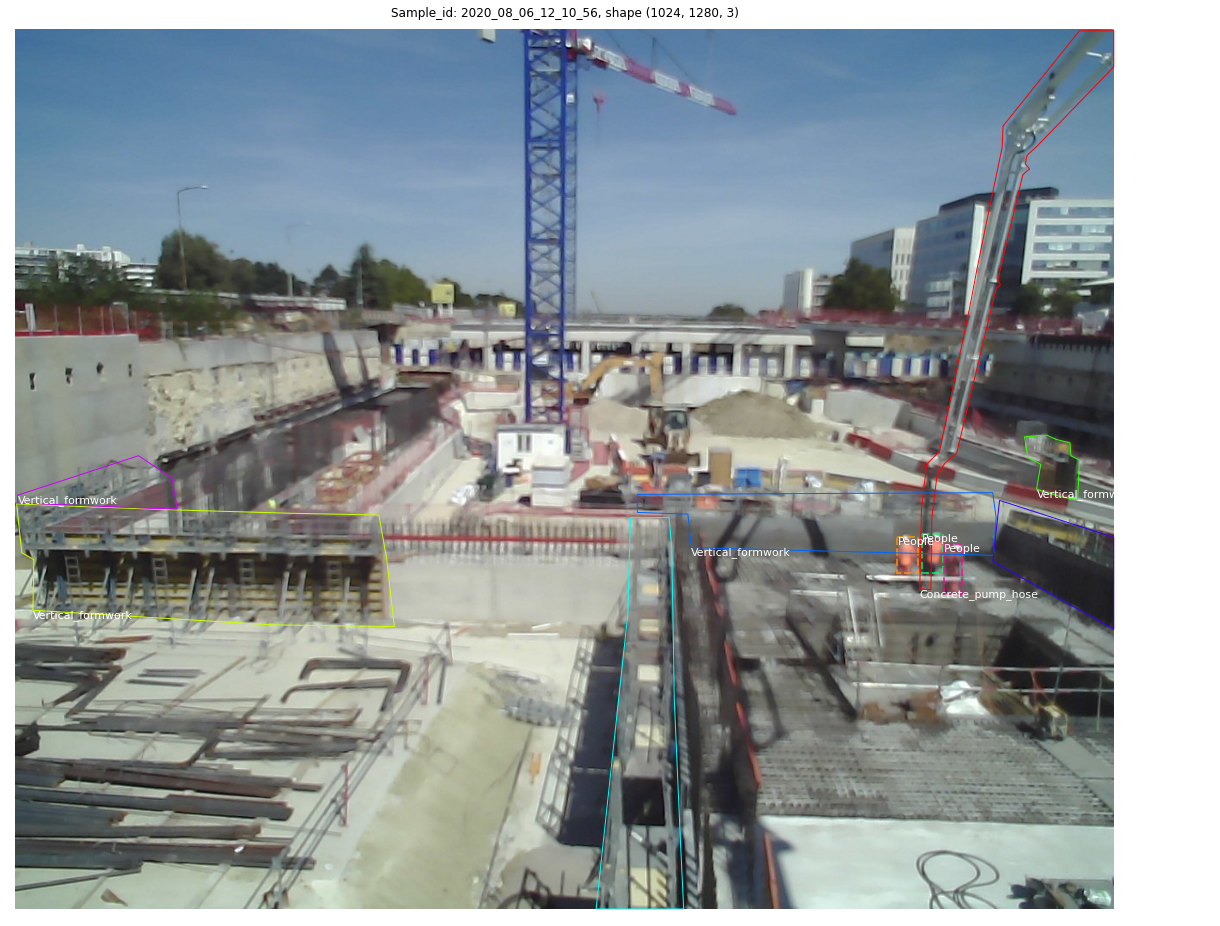

In [9]:
row = records_detect.sample(1).iloc[0]
visualize_sample(row["sample_id"], IMAGE_DIR)

# 3.B. Choose one sample to visualize (Analytics)

<font color='red'> You must upload revised poly_json files to IMAGE_DIR first.</font> </br>
<font color='red'> Otherwise the visualization of polygons will be wrong.</font> </br>

0 peoples + 7 polygons


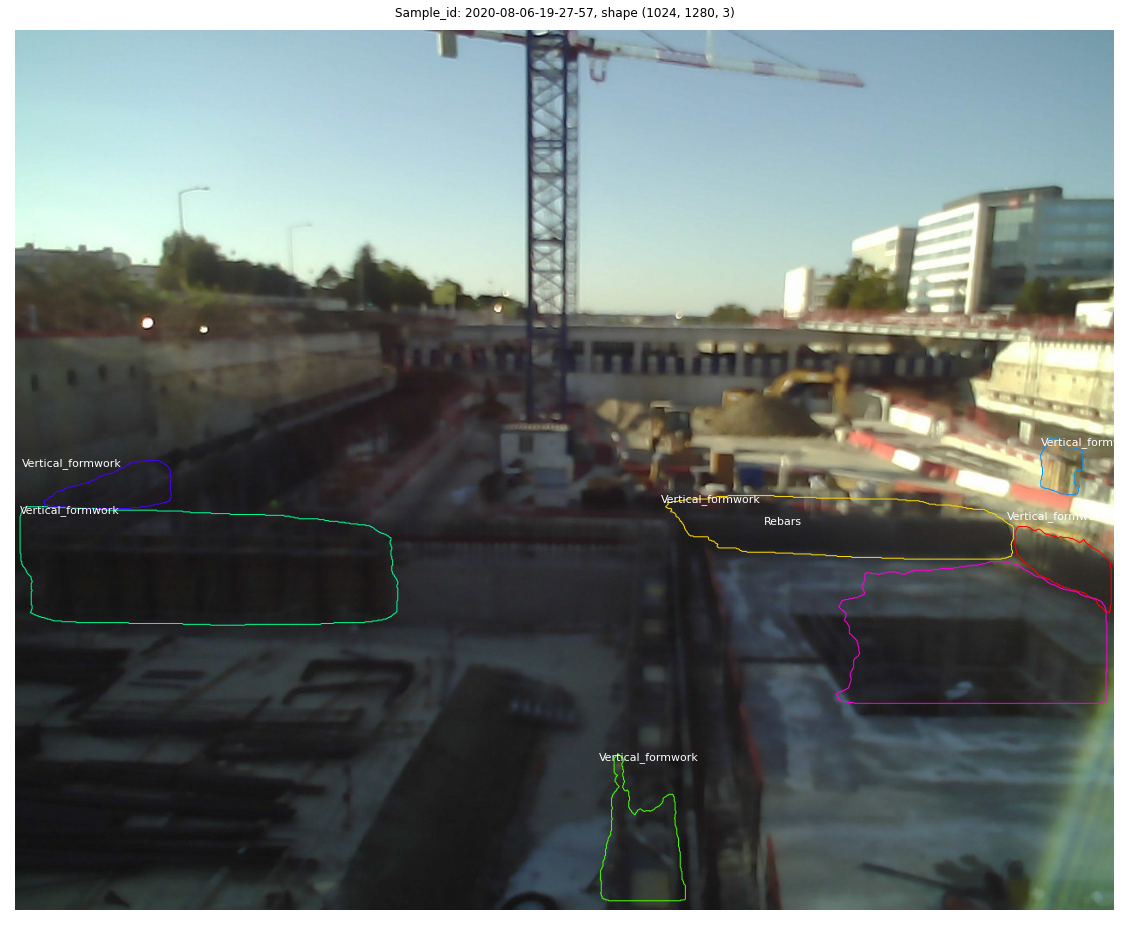

In [11]:
row = records_analytic.sample(1).iloc[0]
visualize_sample_analytic(row["sample_id"], IMAGE_DIR)

# Toy (OPT.) : make gif

In [11]:
import imageio

In [12]:
ra = records[records.construction_site == "Analytic2"]

In [ ]:
with imageio.get_writer('./movie.gif', mode='I', duration = 0.1) as writer:
    for index, row in ra.iterrows():
        tot_number = len(ra)
        if index%50 == 0:
            print(f"{index} / {tot_number}")
        image = read_imageio(get_image_local_path(row["sample_id"], IMAGE_DIR))
        writer.append_data(image)